In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [2]:
NDVI = pd.read_excel("./Used Datasets/NDvi2011-2020.xlsx")
PET = pd.read_excel("./Used Datasets/pet_2010_2020_Scale0.1.xlsx", infer_datetime_format=True)
SolRad = pd.read_excel("./Used Datasets/Srad2010-20.xlsx")
AET = pd.read_excel("./Used Datasets/aet_2010_2020_Scale0.1.xlsx")
Tmin = pd.read_excel("./Used Datasets/tmin.xlsx")
Tmax = pd.read_excel("./Used Datasets/tmax.xlsx")
co2 = pd.read_csv("./Used Datasets/co2_trend_gl_re.txt", delim_whitespace=True)

In [3]:
PAR = np.array(SolRad.values[8 :, 1], dtype=int)*0.1*0.47
NdviArray = np.array(NDVI.values[: -10, 1], dtype=float)
Tavg = (np.array(Tmin.values[8 :, 1], dtype=float) + np.array(Tmax.values[8 :, 1], dtype=float))/20
CO2 = co2.values[:, 3]
W = 0.5 + (np.array(AET.values[17 :,1], dtype=int)/np.array(PET.values[17 :, 1], dtype=int))

In [4]:
W_new = np.zeros(W.size*2, dtype=float)
Tavg_new = np.zeros(Tavg.size*2, dtype=float)
PAR_new = np.zeros(PAR.size*2, dtype=float)
for i in range(Tavg.size):
    W_new[2*i] = W[i]
    Tavg_new[2*i] = Tavg[i]
    PAR_new[i*2] = PAR[i]
    if 2*(i+1)<Tavg_new.size:
        Tavg_new[2*i+1] = (Tavg[i]+Tavg[i+1])/2
        W_new[2*i+1] = (W[i]+W[i+1])/2
        PAR_new[2*i+1] = (PAR[i]+PAR[i+1])/2
Tavg_new[-1] = (Tavg_new[-24]+Tavg_new[-48])/2
W_new[-1] = (W_new[-24]+W_new[-48])/2
PAR_new[-1] = (PAR_new[-24]+PAR_new[-48])/2

W_new = np.zeros(W.size*2, dtype=float)
Tavg_new=np.zeros(Tavg.size*2, dtype=float)
PAR_new = np.zeros(PAR.size*2, dtype=float)
for i in range(Tavg.size):
    Tavg_new[2*i]=Tavg[i]
    Tavg_new[2*i+1]=Tavg[i]
    W_new[2*i] = W[i]
    W_new[2*i+1] = W[i]
    PAR_new[i*2] = PAR[i]
    PAR_new[i*2+1] = PAR[i]

In [5]:
Topt = Tavg_new[-6]
Tmon = Tavg_new
T1 = 0.8 + 0.02*Topt - 0.0005*Topt**2
T2 = 1.185/((1+np.exp(0.2*(Topt-10-Tmon)))*(1+np.exp(0.3*(-Topt-10+Tmon))))
LUE = 2.5*T1*T2*W_new
NPP = NdviArray*PAR_new*LUE
CO2_trend = co2.values[:, 4]

In [6]:
Tyear=np.zeros(8)
#Tmax1 = Tmax.values[8 :, 1]
for i in range(8):
    Tyear[i] = np.sum(Tavg_new[i*24 + 10 : i*24+34])/24
#Tyear[0] = np.sum(Tavg_new[: 10])/10

In [7]:
auto_arima(NPP, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  206
Model:             SARIMAX(4, 0, 3)x(1, 0, [1, 2], 12)   Log Likelihood                -920.501
Date:                                 Fri, 15 May 2020   AIC                           1865.001
Time:                                         13:53:41   BIC                           1904.936
Sample:                                              0   HQIC                          1881.152
                                                 - 206                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     24.7227      4.881      5.065      0.000      15.156      34.289
ar.L1          1.3347      0.144      9.246      0.000       1.052       1.618
ar.L2          0.2827      0.292      0.968      0.333      -0.290       0.855
ar.L3         -1.4269      0.248     -5.747      0.000      -1.913      -0.940
ar.L4          0.5945      0.095      6.256      0.000       0.408       0.781
ma.L1         -0.7317      0.153     -4.785      0.000      -1.031      -0.432
ma.L2         -0.7345      0.207     -3.553      0.000      -1.140      -0.329
ma.L3          0.9850      0.126      7.838      0.000       0.739       1.231
ar.S.L12      -0.9717      0.035    -27.905      0.000      -1.040      -0.903
ma.S.L12       0.8983      0.123      7.290      0.000       0.657       1.140
ma.S.L24       0.0674      0.102      0.663      0.508      -0.132       0.267
sigma2       411.5519     44.212      9.309      0.000     324.899     498.205
===================================================================================
Ljung-Box (Q):                       25.59   Jarque-Bera (JB):               117.64
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             1.03
Prob(H) (two-sided):                  0.91   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
train_data = NPP[:len(NPP)-12]
test_data = NPP[len(NPP)-12:]
arima_model = SARIMAX(train_data, order = (4, 0, 3), seasonal_order = (1, 0, [1, 2], 12))
arima_result = arima_model.fit()
#arima_result.summary()

In [28]:
arima_pred = arima_result.predict(start = len(train_data), end = len(NPP)-1, typ="levels")
arima_pred

array([25.28672958, 13.78769185, 23.74126815, 46.71073159, 90.94120419,
       92.12881582, 79.67641057, 63.03178995, 36.84761581, 36.99430974,
       34.76943415, 41.23857429])

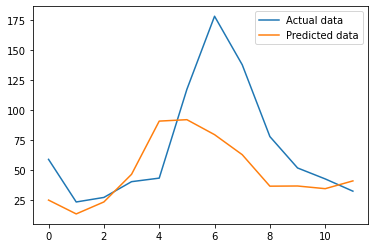

In [29]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(test_data, label="Actual data")
ax.plot(arima_pred, label="Predicted data")
ax.legend()

f.show()